In [1]:
import json
import pandas as pd
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd

from shapely.geometry import box
from shapely.geometry import Point
from geopy.distance import geodesic
from shapely.ops import nearest_points

import utils_RNVI as utils_RNVI

## Methods

In [ ]:
def process_osm_data(place, categories, gdf_districts, crs=4326):
    """
    extract, process, and generate geodataframes for given OSM categories.
    """
    results = {}
    
    for category_name, tags in categories.items():

        # osm data
        gdf_category = ox.geometries_from_place(place, tags)
        
        # convert to points if necessary
        if gdf_category.geometry.geom_type.isin(['Polygon', 'MultiPolygon']).any():
            gdf_category['geometry'] = gdf_category.geometry.centroid
        gdf_category = gdf_category.to_crs(epsg=crs)
        
        # spatial join with districts
        gdf_category_district = gpd.sjoin(gdf_category, gdf_districts, how="inner", predicate='within')
        
        # count the number of locations per district
        counts = gdf_category_district.groupby('BEZNR').size()
        gdf_districts_category = gdf_districts.merge(counts.rename(f'count_{category_name}'), on='BEZNR', how='left')
        
        # calculate percentage distribution across districts
        total_count = gdf_districts_category[f'count_{category_name}'].sum()
        gdf_districts_category[f'percentage_{category_name}'] = (
            gdf_districts_category[f'count_{category_name}'] / total_count * 100
        )
    
        results[category_name] = {
            'points': gdf_category,
            'districts': gdf_districts_category
        }
    
    return results


def add_nearest_category_column(gdf_nodes, gdf_category, column_name):
    """
    adds a column to gdf_nodes indicating whether a node is the nearest to any point in gdf_category.
    """
    nearest_nodes_idx = []

    # find the nearest node for each point in gdf_category
    for category_point in gdf_category.geometry:
        nearest_idx = gdf_nodes.geometry.distance(category_point).idxmin()
        nearest_nodes_idx.append(nearest_idx)

    gdf_nodes[column_name] = False
    gdf_nodes.loc[nearest_nodes_idx, column_name] = True

    return gdf_nodes

## Generate spatial and network data

- source Census and districts data: https://www.data.gv.at/katalog/en/dataset/stadt-wien_bezirksgrenzenwien
- generate networkx graph and geodataframes necessary to compute the RNVI index

In [2]:
shapefile_path = "../data/BEZIRKSGRENZEOGD/BEZIRKSGRENZEOGDPolygon.shp"
shapefile_path_census = "../data/ZAEHLBEZIRKOGD/ZAEHLBEZIRKOGDPolygon.shp"

# Load the shapefile into a GeoDataFrame
gdf_districts = gpd.read_file(shapefile_path)
gdf_census = gpd.read_file(shapefile_path_census)

gdf_districts['DISTRICT_CODE'] = gdf_districts.apply( lambda row: str(int(row['STATAUSTRI']*100)), axis = 1)
gdf_districts = gdf_districts.to_crs(epsg=4326)

In [3]:
# categories to extract from OSM
categories = {
    'hospitals': {'amenity': 'hospital'},
    'police': {'amenity': 'police'},
    'religious': {'amenity': ['place_of_worship', 'church', 'mosque', 'temple', 'synagogue']},
    'malls': {'shop': 'mall'}
}

place = "Vienna, Austria"
results = process_osm_data(place, categories, gdf_districts)

# individual results
gdf_hospitals = results['hospitals']['points']
gdf_districts_hospitals = results['hospitals']['districts']

gdf_police = results['police']['points']
gdf_districts_police = results['police']['districts']

gdf_religious = results['religious']['points']
gdf_districts_religious = results['religious']['districts']

gdf_malls = results['malls']['points']
gdf_districts_malls = results['malls']['districts']


/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2879791448.py:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_category = ox.geometries_from_place(place, tags)
/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2879791448.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_category['geometry'] = gdf_category.geometry.centroid
/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2879791448.py:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` mod

# network analysis

In [5]:
#network extraction
#location_point = (48.2082, 16.3738)
#distance = 3000

# OSM extraction of the network
city_name = "Wien, Austria"
G_city = ox.graph_from_place(city_name, network_type='drive', simplify=True)

# trasform to undirected (approximation)
G_city = nx.to_undirected(G_city)

/opt/homebrew/Caskroom/miniforge/base/envs/py3/lib/python3.9/site-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


In [7]:
#G_projected = ox.project_graph(G_city) # in 4326
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_city, nodes=True, edges=True)

### associate nodes and edges to districts

In [10]:
# join network with districts
gdf_edges = gdf_edges.reset_index()
gdf_edges = gdf_edges.to_crs(gdf_districts.crs)
gdf_edges['centroid'] = gdf_edges.geometry.centroid

# geodataframe of the centroids
gdf_centroids = gpd.GeoDataFrame(gdf_edges[['centroid']], geometry='centroid', crs=gdf_edges.crs)
gdf_centroids_districts = gpd.sjoin(gdf_centroids, gdf_districts[['geometry', 'STATAUSTRI']], how='left', predicate='within')

gdf_edges['STATAUSTRI'] = gdf_centroids_districts['STATAUSTRI'].values
gdf_edges.drop(columns='centroid', inplace=True)

gdf_nodes = gdf_nodes.to_crs(gdf_districts.crs)
gdf_nodes = gpd.sjoin(gdf_nodes, gdf_districts[['geometry', 'STATAUSTRI']], how='left', predicate='within')
gdf_nodes = gdf_nodes.drop(columns=['index_right'])

/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2884832780.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_edges['centroid'] = gdf_edges.geometry.centroid


In [11]:
#filtered_edges = gdf_edges.to_crs(epsg=4326)
#gdf_districts_police = gdf_districts_police.to_crs(epsg=4326)

### associate to each node the presence of a POI

In [12]:
# add police
gdf_nodes = add_nearest_category_column(gdf_nodes, gdf_police, 'police')
# add hospitals
gdf_nodes = add_nearest_category_column(gdf_nodes, gdf_hospitals, 'hospitals')
# add religious
gdf_nodes = add_nearest_category_column(gdf_nodes, gdf_religious, 'religious')
# add malls
gdf_nodes = add_nearest_category_column(gdf_nodes, gdf_malls, 'malls')

/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2876440237.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = gdf_nodes.geometry.distance(category_point).idxmin()
/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2876440237.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = gdf_nodes.geometry.distance(category_point).idxmin()
/var/folders/ms/3n67wbb95xn26d6lg9q5sjw40000gn/T/ipykernel_2725/2876440237.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = gdf_nodes.geometry.distance(category_point).i

### parse road network

In [15]:
# road types in highway
road_types = gdf_edges['highway'].explode().unique().tolist()

# keep only the first element if the entry is a list
gdf_edges['highway'] = gdf_edges['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)

# mapping dictionary
highway_mapping = {
    'primary': 'primary_road',
    'primary_link': 'primary_road',
    'motorway': 'primary_road',
    'motorway_link': 'primary_road',
    'trunk': 'primary_road',
    'trunk_link': 'primary_road',
    'secondary': 'secondary_road',
    'secondary_link': 'secondary_road',
    'tertiary': 'tertiary_road',
    'tertiary_link': 'tertiary_road'
}

# default category for all other roads
gdf_edges['road_classification'] = gdf_edges['highway'].map(highway_mapping).fillna('residential_road')

# color mapping for each road type
color_mapping = {}
color_mapping['residential_road']='gray'
color_mapping['tertiary_road']='sandybrown'
color_mapping['secondary_road']= 'coral'
color_mapping['primary_road']= 'red'


In [17]:
df = gdf_edges

In [18]:
highway_types = road_types

# clean columns
def clean_column(col):
    def safe_numeric(x):

        if isinstance(x, list):
            x = x[0]
        # try to convert to float, otherwise return NaN
        try:
            return float(x)
        except (ValueError, TypeError):
            return np.nan
    
    return col.apply(safe_numeric)

# preprocess maxspeed and lanes
df['maxspeed'] = clean_column(df['maxspeed'])
df['lanes'] = clean_column(df['lanes'])

In [20]:

# fill NaN values with median for each highway type
for hwy_type in highway_types:
    subset = df[df['highway'] == hwy_type]
    
    # median for maxspeed and lanes
    median_maxspeed = subset['maxspeed'].median()
    median_lanes = subset['lanes'].median()
    
    # fill NaN values with median of that typw
    df.loc[df['highway'] == hwy_type, 'maxspeed'] = subset['maxspeed'].fillna(median_maxspeed)
    df.loc[df['highway'] == hwy_type, 'lanes'] = subset['lanes'].fillna(median_lanes)

    # count NaN values after filling (should be 0)
    nan_maxspeed = df.loc[df['highway'] == hwy_type, 'maxspeed'].isna().sum()
    nan_lanes = df.loc[df['highway'] == hwy_type, 'lanes'].isna().sum()
    total_rows = len(subset)

    print(f" road type: {hwy_type}")
    print(f"  total rows: {total_rows}")
    print(f"  median for 'maxspeed': {median_maxspeed}")
    print(f"  median for 'lanes': {median_lanes}")



Highway Type: secondary
  Total Rows: 2684
  Median for 'maxspeed': 50.0
  Median for 'lanes': 2.0
  NaN values in 'maxspeed' after filling: 0
  NaN values in 'lanes' after filling: 0
Highway Type: tertiary
  Total Rows: 2601
  Median for 'maxspeed': 50.0
  Median for 'lanes': 2.0
  NaN values in 'maxspeed' after filling: 0
  NaN values in 'lanes' after filling: 0
Highway Type: residential
  Total Rows: 15484
  Median for 'maxspeed': 30.0
  Median for 'lanes': 1.0
  NaN values in 'maxspeed' after filling: 0
  NaN values in 'lanes' after filling: 0
Highway Type: living_street
  Total Rows: 445
  Median for 'maxspeed': 20.0
  Median for 'lanes': 1.0
  NaN values in 'maxspeed' after filling: 0
  NaN values in 'lanes' after filling: 0
Highway Type: primary
  Total Rows: 1891
  Median for 'maxspeed': 50.0
  Median for 'lanes': 2.0
  NaN values in 'maxspeed' after filling: 0
  NaN values in 'lanes' after filling: 0
Highway Type: secondary_link
  Total Rows: 52
  Median for 'maxspeed': 50.0
 

In [21]:
gdf_edges = df

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,reversed,...,geometry,width,ref,bridge,tunnel,junction,access,service,STATAUSTRI,road_classification
0,199735,33183691,0,25498425,True,2.0,Auerspergstraße,secondary,50.0,False,...,"LINESTRING (16.35586 48.20684, 16.35582 48.206...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,907.0,secondary_road
1,199735,365385909,0,4997667,True,1.0,Schmerlingplatz,tertiary,30.0,False,...,"LINESTRING (16.35586 48.20684, 16.3559 48.2068...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,901.0,tertiary_road
2,199735,277838150,0,576889186,True,2.0,Lerchenfelder Straße,secondary,50.0,False,...,"LINESTRING (16.35571 48.20679, 16.35579 48.206...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,907.0,secondary_road
3,199735,1151549071,0,155492879,True,2.0,Museumstraße,secondary,50.0,False,...,"LINESTRING (16.35609 48.20663, 16.35594 48.206...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,907.0,secondary_road
4,199736,33183691,0,44352609,True,2.0,Auerspergstraße,secondary,50.0,False,...,"LINESTRING (16.35574 48.20696, 16.35569 48.207...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,908.0,secondary_road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23985,11778060306,11778060308,0,482008866,True,4.0,Kärntner Ring,secondary,50.0,False,...,"LINESTRING (16.37437 48.20166, 16.37428 48.201...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,901.0,secondary_road
23986,11882020970,11882020972,0,1279992443,False,1.0,NaN,living_street,20.0,False,...,"LINESTRING (16.26731 48.18499, 16.26739 48.184...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,913.0,residential_road
23987,11986917488,11986917489,0,10491442,False,2.0,Wolfgang-Mühlwanger-Straße,tertiary,30.0,True,...,"LINESTRING (16.51928 48.23104, 16.51843 48.23107)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,922.0,tertiary_road
23988,12001567799,12001567800,0,"[26228241, 26505726, 26505727]",True,1.0,"[Kalmanstraße, Kalmanbrücke]",residential,30.0,False,...,"LINESTRING (16.26885 48.16516, 16.26891 48.165...",NaN,NaN,yes,NaN,NaN,NaN,NaN,913.0,residential_road


In [22]:
# check 'maxspeed' values are all floats
for index, row in gdf_edges.iterrows():
    if not isinstance(row['maxspeed'], float):
        print(f"Problem detected in row {index}: 'maxspeed' is not a float. Value: {row['maxspeed']}")

# missing edges
G_undirected = G_city
missing_edges_count = 0

# set of edges from gdf_edges
edges_in_gdf = set(zip(gdf_edges['u'], gdf_edges['v'], gdf_edges['key']))

# update the attributes of the graph edges based on the updated df
for _, row in gdf_edges.iterrows():

    u, v, key = row['u'], row['v'], row['key']
    maxspeed = row['maxspeed']
    lanes = row['lanes']
    
    # graph edge attributes
    if G_undirected.has_edge(u, v, key):  # Ensure the edge exists
        G_undirected[u][v][key]['maxspeed'] = maxspeed
        G_undirected[u][v][key]['lanes'] = lanes
    else:
        missing_edges_count += 1

# check if there are edges in the graph that are not in the df
extra_edges_in_graph = [
    (u, v, key) for u, v, key in G_undirected.edges(keys=True)
    if (u, v, key) not in edges_in_gdf
]

if extra_edges_in_graph:
    print("Edges in the graph but not in the DataFrame:")
    for edge in extra_edges_in_graph:
        print(edge)
else:
    print("No extra edges in the graph.")

print(f"Number of edges in the DataFrame not found in the graph: {missing_edges_count}")


No extra edges in the graph.
Number of edges in the DataFrame not found in the graph: 0


## Save data structures and visualize

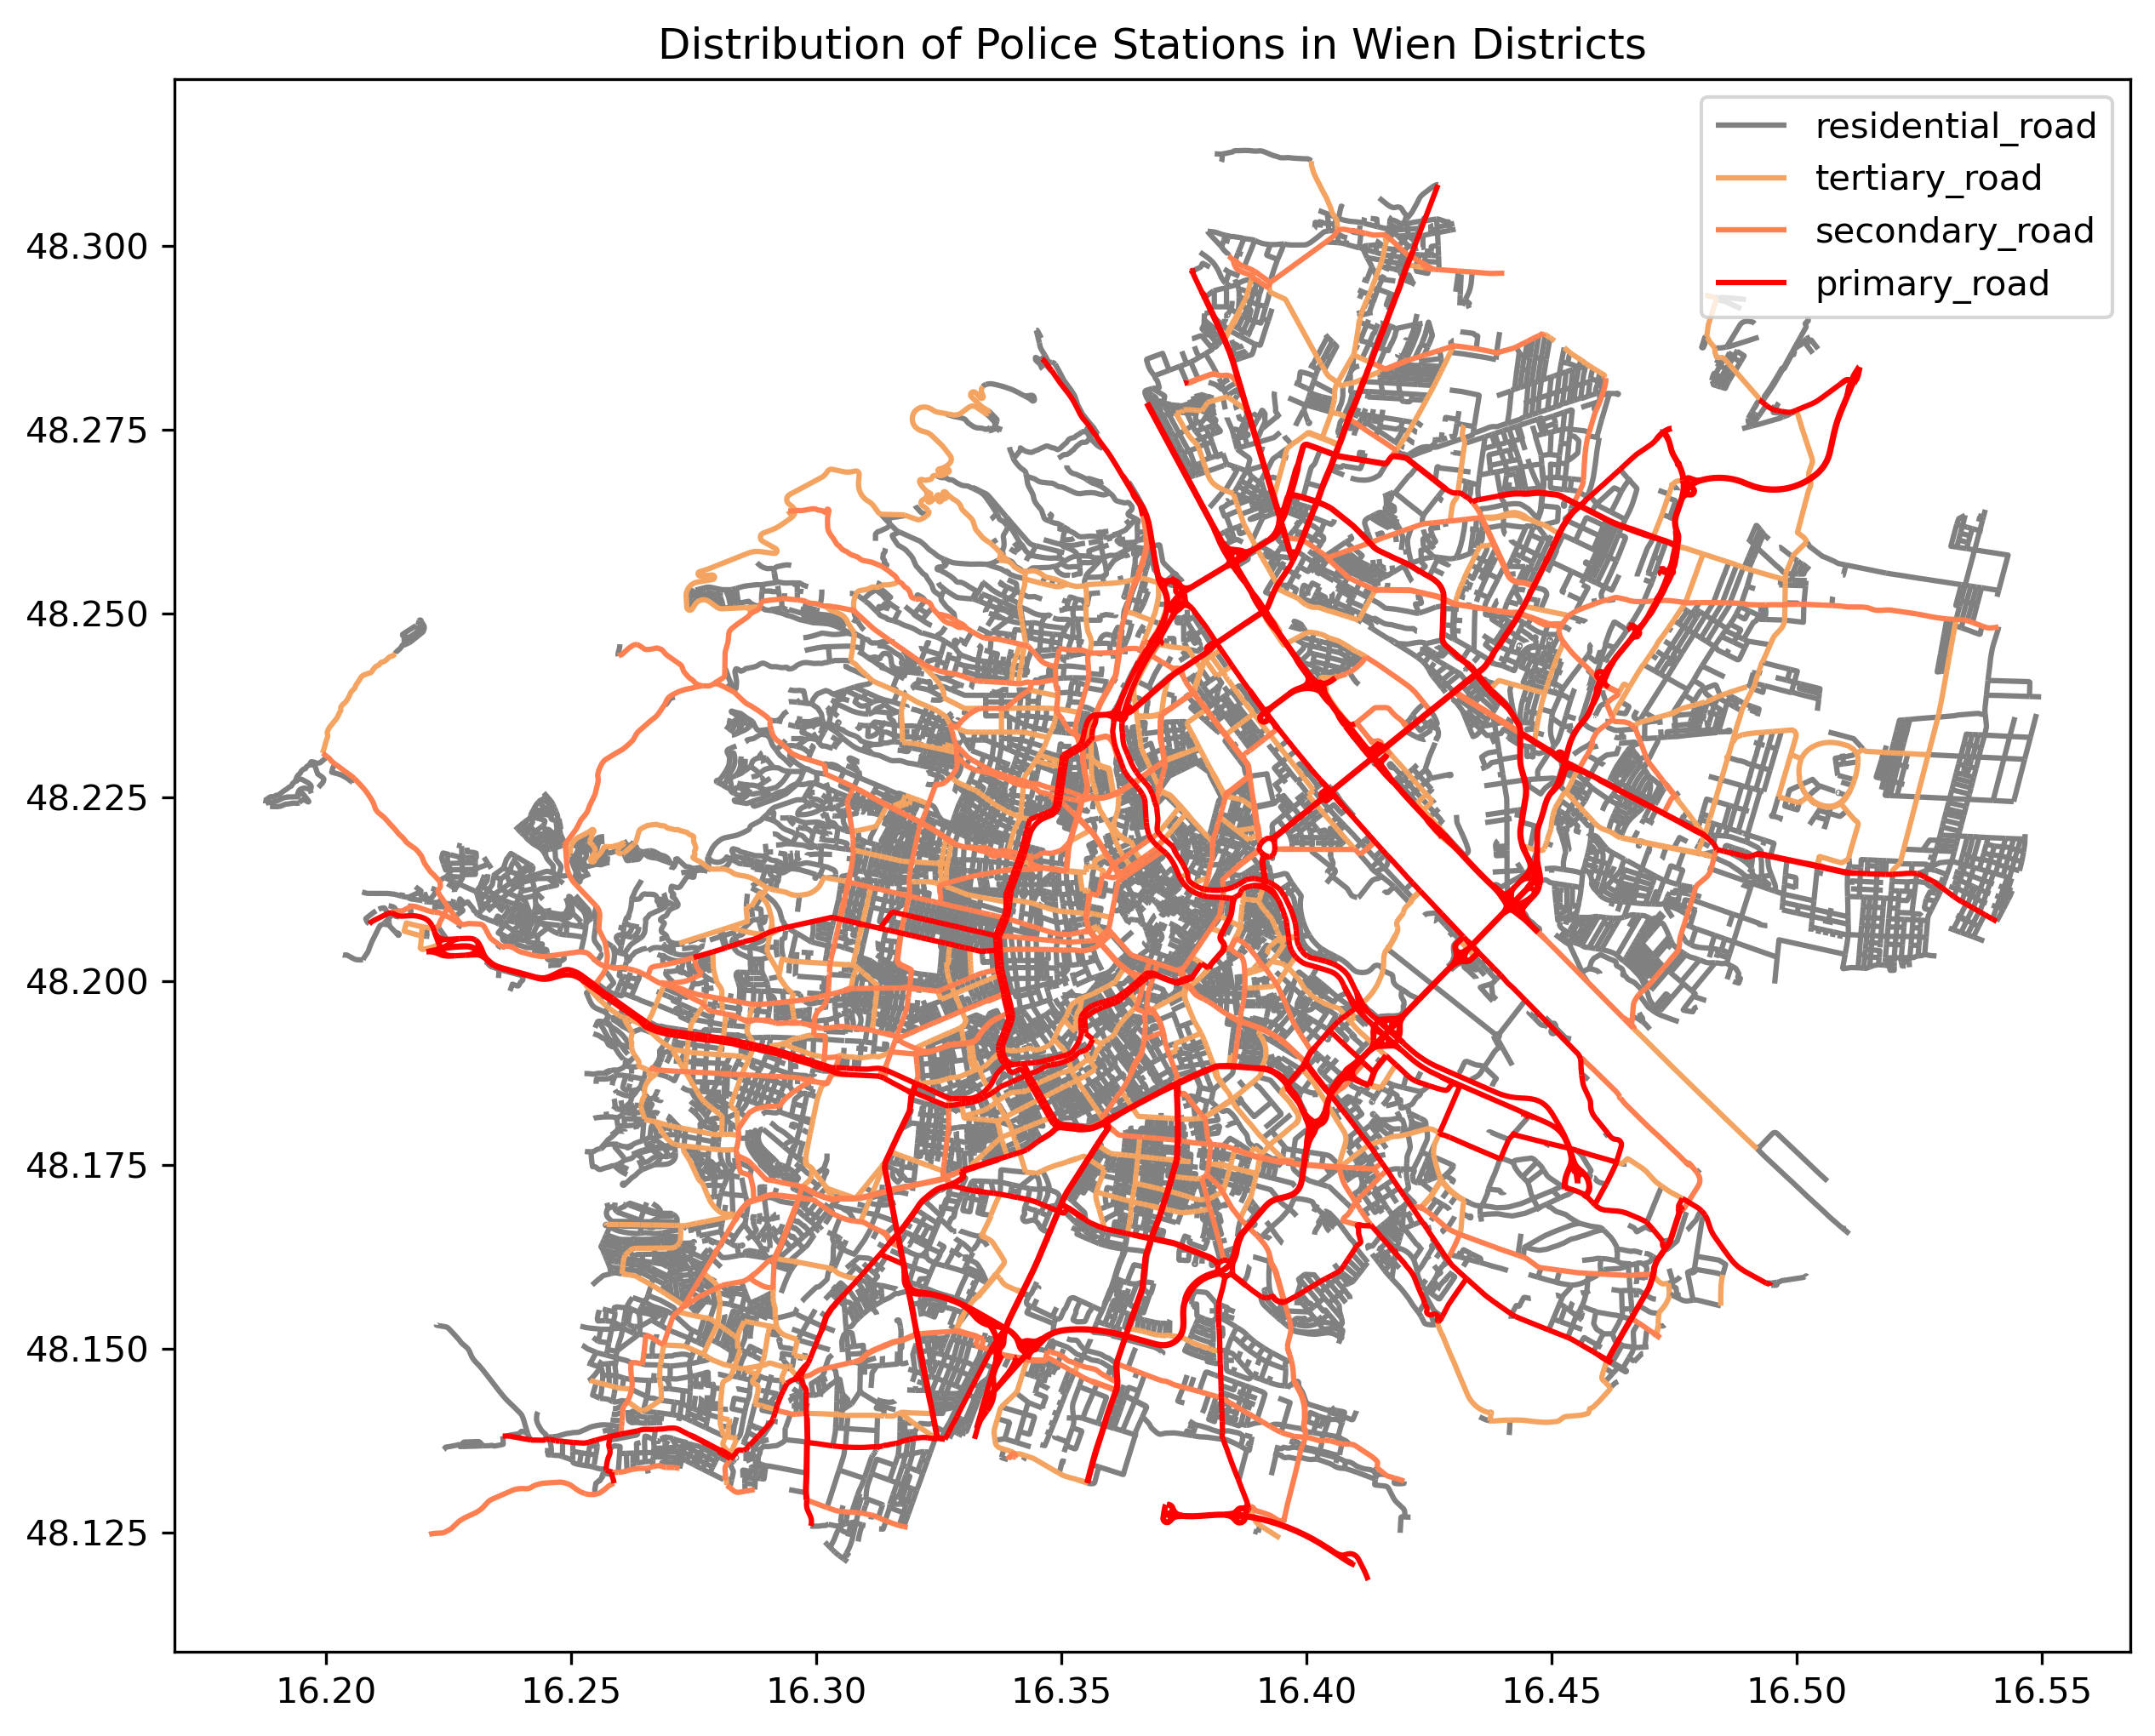

In [23]:
# viz road network with color mapping
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi = 300)
for road_type, color in color_mapping.items():
    gdf_edges[gdf_edges['road_classification'] == road_type].plot(ax=ax, color=color, label=road_type)

plt.title("Distribution of Police Stations in Wien Districts")
plt.legend()
plt.show()

In [24]:
gdf_nodes = gdf_nodes.reset_index()
gdf_edges = gdf_edges.reset_index()

In [25]:
# gdf_nodes as geojson
gdf_nodes.to_file("../processed/wien_gdf_nodes.geojson", driver="GeoJSON")
# gdf_edges as geojson
gdf_edges.to_file("../processed/wien_gdf_edges.geojson", driver="GeoJSON")


GeoJSON files saved: gdf_nodes.geojson and gdf_edges.geojson


In [29]:
import pickle
# check and clean edge attributes before saving the graph
for u, v, data in G_undirected.edges(data=True):

    if 'maxspeed' in data:
        if isinstance(data['maxspeed'], list):
            print(f"Problem detected: 'maxspeed' is a list for edge ({u}, {v}). Taking the first value: {data['maxspeed'][0]}")
            data['maxspeed'] = data['maxspeed'][0]  # Take the first value of the list

    if 'lanes' in data:
        if isinstance(data['lanes'], list):
            print(f"Problem detected: 'lanes' is a list for edge ({u}, {v}). Taking the first value: {data['lanes'][0]}")
            data['lanes'] = data['lanes'][0]  # Take the first value of the list


# store with pickle
with open("../processed/wien_G_undirected_new.pkl", "wb") as f:
    pickle.dump(G_undirected, f)


Graph saved as wien_G_undirected.pkl
